### Jay Gapuz
### ME EE
### EE 298 PCA/GMMM 

In [14]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import math

#### Prerequisite: Download the STL-10 dataset 
##### Referenced from: https://ai.stanford.edu/~acoates/stl10/
- Run the provided python script to download the dataset from: https://github.com/mttk/STL10   
  `stl10_input.py`
- Access the datasets in the designated folder. For this project, I used the functions from the python script to read the files



In [96]:
# Function to read the files, referenced from stl10_input.py
def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images

def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels

In [112]:
# Path of the files and the filenames:
# Unlabeled dataset
DATA_PATH_UNLABELED_X = './data/stl10_binary/unlabeled_X.bin'
DATA_PATH_TEST_X = './data/stl10_binary/test_X.bin'
DATA_PATH_TEST_Y = './data/stl10_binary/test_Y.bin'
DATA_PATH_TRAIN_X = './data/stl10_binary/train_X.bin'
DATA_PATH_TRAIN_Y = './data/stl10_binary/train_Y.bin'

In [17]:
# Plotting and image conversion functions:
# Util function for displaying images in a grid (referenced from Prof Atienza repo)
def plot_images(images, title = 'default', n_images=25):
    plt.figure(figsize=(10,10))
    plt.suptitle(title, fontsize=20)
    side = int(math.sqrt(n_images))
    for i in range(n_images):
        plt.subplot(side, side, i + 1)
        image = images[i]
        plt.imshow(image,cmap='gray', vmin=0, vmax=255)
        plt.axis('off')
    plt.show()
    plt.close('all')  

# Convert RGB image to grayscale
def color2gray(image):
    return image[..., :3] @ [0.299, 0.587, 0.114] 

## Dataset Preparation  
Read the unlabeled dataset  
Convert to grayscale  

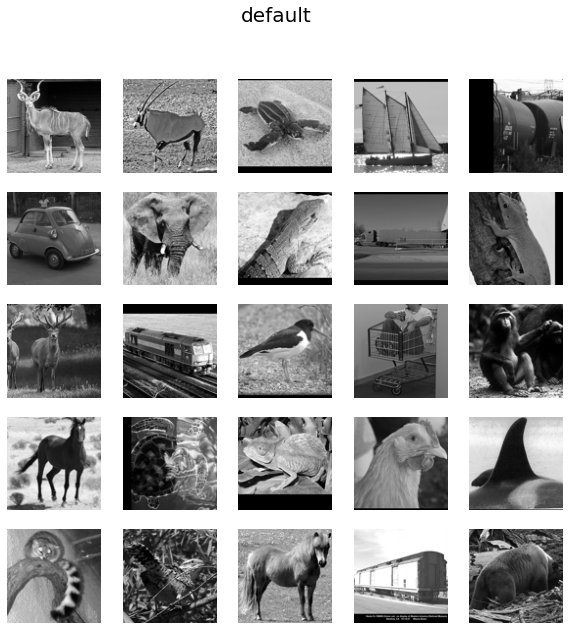

In [18]:
unlabeled_images = read_all_images(DATA_PATH_UNLABELED_X)
unlabeled_images = np.array([color2gray(i) for i in unlabeled_images])
plot_images(unlabeled_images)

## PCA
Part 1: Low-dimensionality reduction using PCA  
Using STL-10 10k unlabeled dataset, build a PCA with the minimum dimensionality and best reconstruction quality  
Plot 𝑀𝑆𝐸 vs 𝒛−𝑑𝑖𝑚   
  Mean squared error for the entire test set vs 𝒛 code dimensionality  
Try the following dims: {32, 64, 256, 512, 1028, 2046, 4098}

In [19]:
def compute_PCA(images_flat , n_components):
    '''
    images_flat - flattened images in numpy array
    n_components - number of z dimensions
    '''
     
    # We will subtract the mean of each image, then get the covariance matric
    images_mean = images_flat - np.mean(images_flat , axis = 0)
    cov_mat = np.cov(images_mean , rowvar = False)
     
    # Using linalg, we will get the eigenvalues and eigenvectors
    eigenvals , eigenvecs = np.linalg.eigh(cov_mat)
     
    # Rearrange  the eigenvalues and eigenvectors in descending order
    eigenvals_new = eigenvals[np.argsort(eigenvals)[::-1]]
    eigenvecs_new = eigenvecs[:,np.argsort(eigenvals)[::-1]]
     
    #Get only the n components
    eigenvecs_dim = eigenvecs_new[:,0:n_components]
     
    # We will now apply transformation to the images
    images_flat_reduced = np.dot(eigenvecs_dim.T , images_mean.T).T
    

     
    return images_flat_reduced, eigenvecs_dim

# Inverse transform the reduced images to original 
# We will use this:
# PCA reconstruction = (PC scores (.) Eigenvectors.⊤)  +  Mean

def inverse_PCA(X_flat,X_reduced,eigenvecs):
    return np.dot(X_reduced, eigenvecs.T) + np.mean(X_flat,axis = 0)

Utility functions

In [20]:

# Flatten the images
def flatten_all(images): # images must be in numpy array format
    return np.array([i.flatten() for i in images])

# Compute the mean squred error
def compute_mse(original, reduced):
    return (np.square(original- reduced)).mean(axis=None)

# Convert the flattened images to original shape
def reshape_images(images):
    return np.array([np.reshape(i,(96,96)) for i in images])
    

Perform PCA on different dimensions then choose the proper z dimension based from the mean squared error

dimension:  32    mse:  1180.7847941324972
dimension:  64    mse:  913.25526628818
dimension:  256    mse:  488.3850313099868
dimension:  512    mse:  323.3114798713665
dimension:  1028    mse:  185.52582327952226
dimension:  2046    mse:  80.68422217842823
dimension:  4098    mse:  17.5506714775561


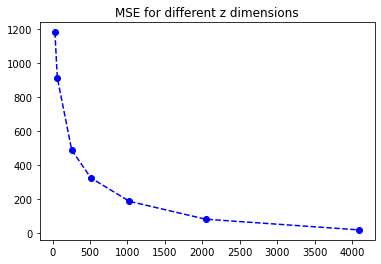

In [24]:
# We will do PCA for different dimensions the get the MSE for each dimension
orig_images = unlabeled_images[0:10000]
flat_images = flatten_all(orig_images)

MSE = []
n_components = [32, 64, 256, 512, 1028, 2046, 4098]

for n in n_components:
    PCA_reduced,eigenvecs =  compute_PCA(flat_images,n)
    compress_images = inverse_PCA(flat_images,PCA_reduced,eigenvecs)
    mse = compute_mse(flat_images,compress_images)
    print('dimension: ',n, "   mse: ", mse)
    MSE.append(mse)

# Visualize the mse
plt.plot(n_components, MSE, '--bo')
plt.title('MSE for different z dimensions')
plt.show()
plt.close('all')



We'll reference the elbow of the MSE plot.  
512 to 1028 z dim are the soft spot, with lower dimension and acceptable mse for the unlabeled dataset. 

Verify the results with the test data


dimension:  32    mse:  1172.2549920729718
dimension:  64    mse:  906.7388302628807
dimension:  256    mse:  480.4076639868566
dimension:  512    mse:  313.4479106293432
dimension:  1028    mse:  174.29704570634203
dimension:  2046    mse:  70.65566082913746
dimension:  4098    mse:  12.44530759481375


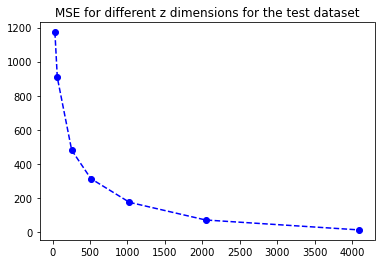

In [33]:
# Verify the result with the test dataset
test_images = read_all_images(DATA_PATH_TEST_X)
test_images = np.array([color2gray(i) for i in test_images])
orig_images = test_images
flat_images = flatten_all(orig_images)

MSE = []
n_components = [32, 64, 256, 512, 1028, 2046, 4098]

for n in n_components:
    PCA_reduced,eigenvecs =  compute_PCA(flat_images,n)
    compress_images = inverse_PCA(flat_images,PCA_reduced,eigenvecs)
    mse = compute_mse(flat_images,compress_images)
    print('dimension: ',n, "   mse: ", mse)
    MSE.append(mse)

# Visualize the mse
plt.plot(n_components, MSE, '--bo')
plt.title('MSE for different z dimensions for the test dataset')
plt.show()
plt.close('all')


##### Although 4098 has the lowest MSE, the number of dimension is quite high. That's half of the total image dimension. We will be using the 1028 dimension from the elbow check.
#### We want the lowest z-dimension with optimized mse

### MSE = 174.3

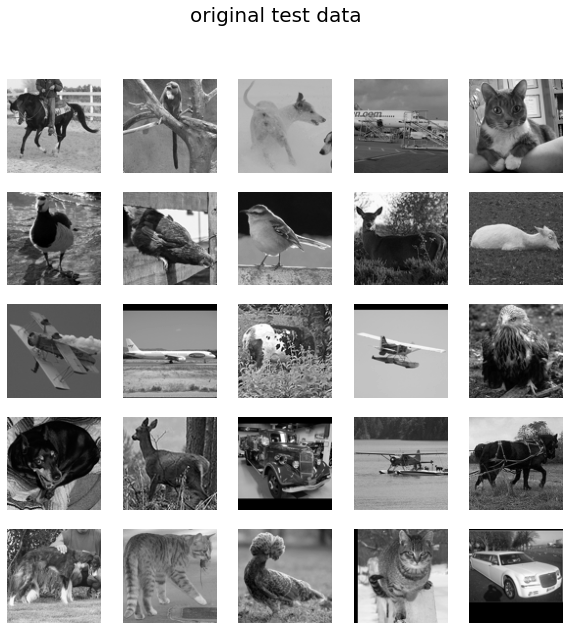

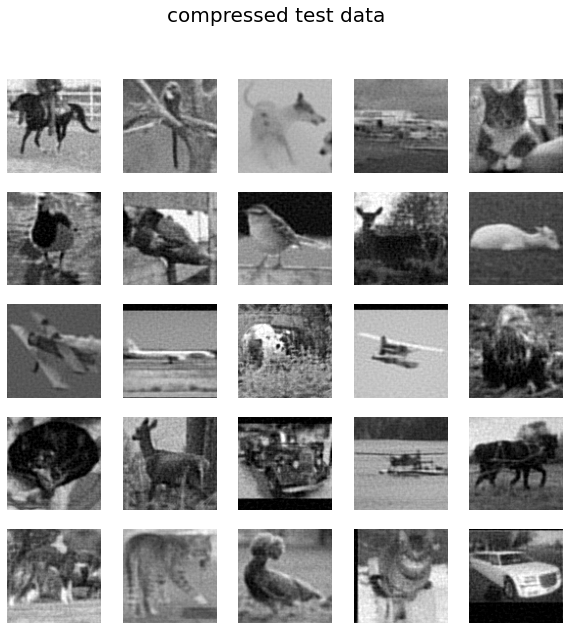

In [36]:
plot_images(test_images,title = "original test data")
PCA_reduced,eigenvecs =  compute_PCA(flat_images,1028)
compress_images = inverse_PCA(flat_images,PCA_reduced,eigenvecs)
plot_images(reshape_images(compress_images), title = 'compressed test data')

## GMM

Can we fit a 10-component GMM on the unlabeled dataset 𝒛 code vectors from PCA?  
Can we use the GMM and labeled train set to assign labels to the 10 clusters in GMM?  
Report the accuracy on the test dataset.  
Can we build an STL generative model using unlabeled dataset  PCA 𝒛 code vectors and GMM?   

In [111]:
# Try to fit a GMM using the mixture package from sklearn
from sklearn import mixture as mx

orig_images = unlabeled_images[0:10000]
flat_images = flatten_all(orig_images)
PCA_reduced,eigenvecs =  compute_PCA(flat_images,1024)

gmm_model = mx.GaussianMixture(n_components=10,random_state = 0)
gmm_model.fit(PCA_reduced)
    

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=10, n_init=1,
                precisions_init=None, random_state=0, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [113]:
# Get the corresponding cluster of the unlabeled dataset using z-dim (PCA) = 10
gmm_clusters = gmm_model.predict(PCA_reduced)

In [114]:
reconstructed_images = inverse_PCA(flat_images,PCA_reduced,eigenvecs)
reconstructed_images = reshape_images(reconstructed_images)
arr_images = []
arr_images_orig = []
n = 0
for i in gmm_clusters:
    arr_images.append([i,reconstructed_images[n]])
    arr_images_orig.append([i,orig_images[n]])
    n = n + 1

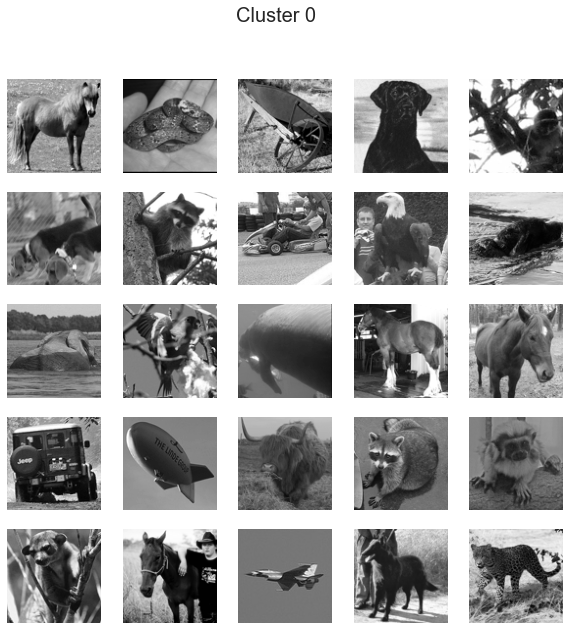

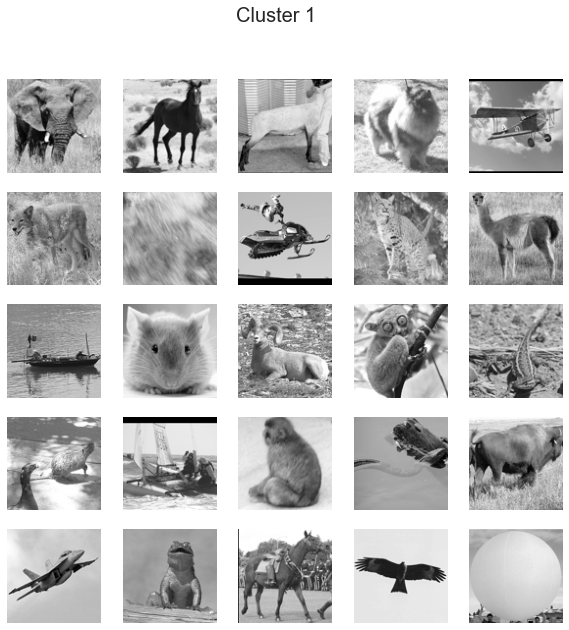

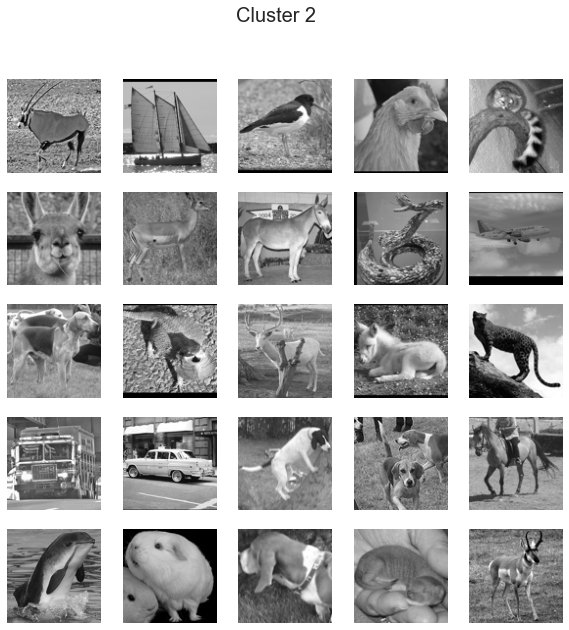

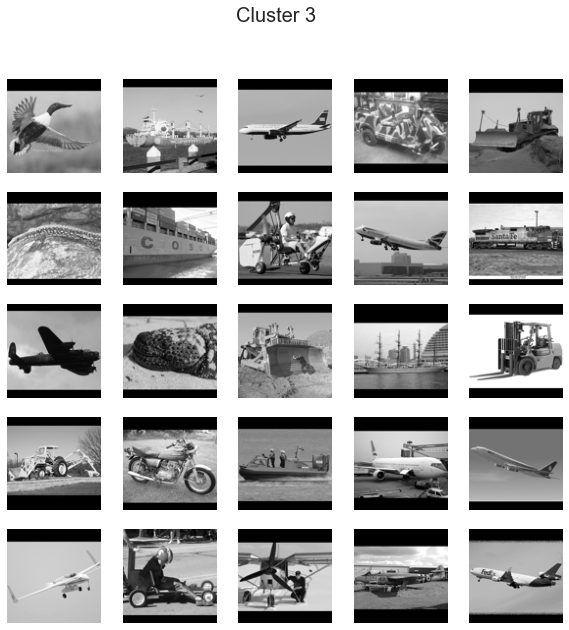

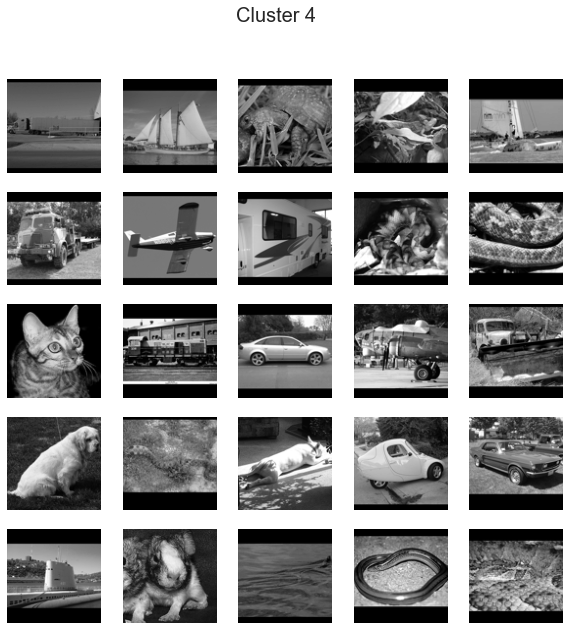

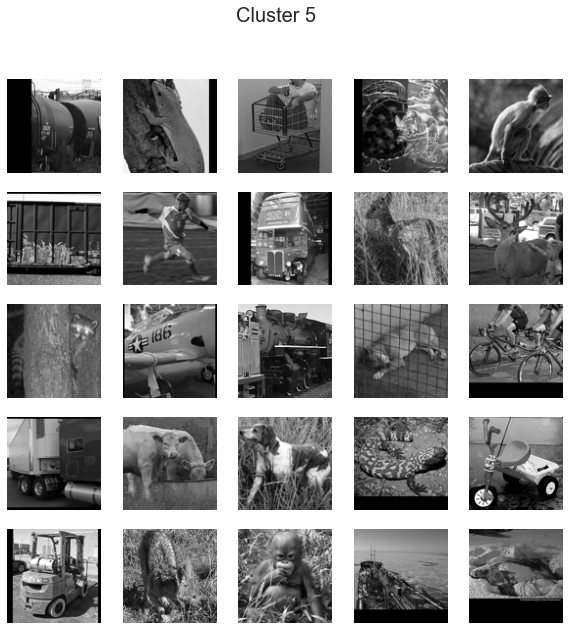

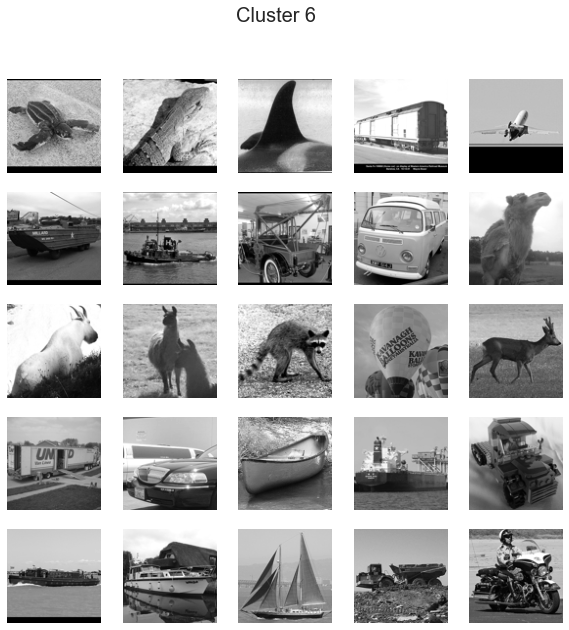

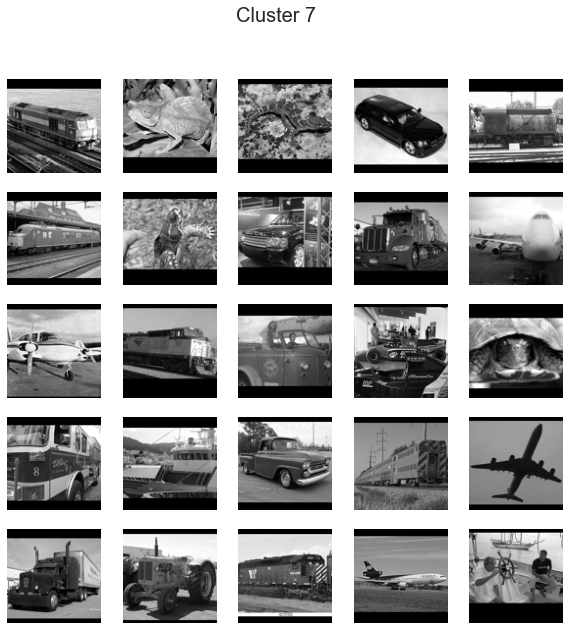

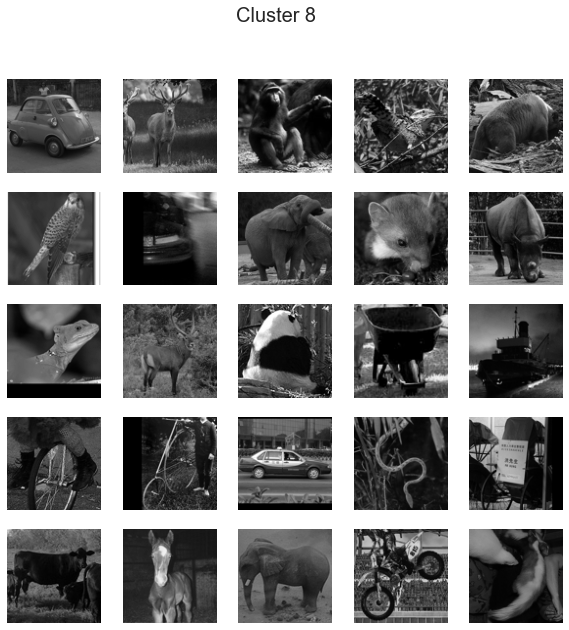

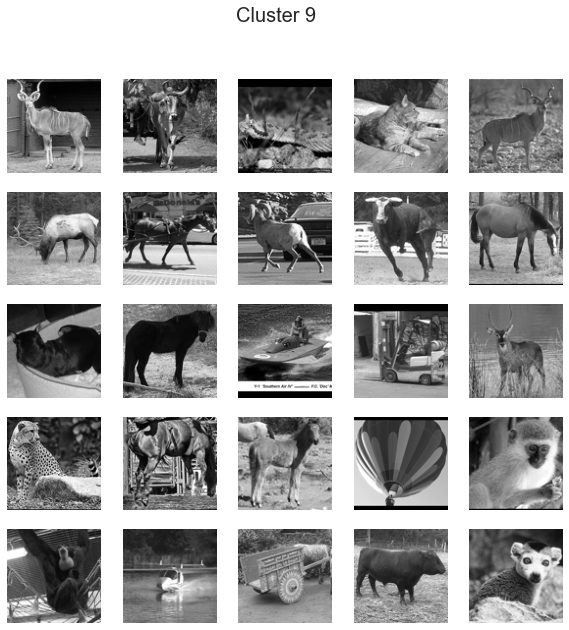

In [115]:
# Note we will use the original images as reference for visualization purposes
for i in np.unique(gmm_clusters):
    clustered_images = []
    for arr in arr_images_orig:
        if arr[0] == i: clustered_images.append(arr[1])

    plot_images(clustered_images,title = "Cluster "+ str(i))
        

#### From the results of the cluster, we can notice that those with similar pattern/alignment like cars are clustered together (Ex. Cluster 7). However there are severa clusters form are majority based from the darkness or lightness of the image.
#### Example: 
##### Those with sky and light background tends to be in the same cluster.  (Cluster 3)
##### Those with dark edges are clustered together (Cluster 4)

In [121]:
# Try with the test data:
# Try to model the train  the resulting GMM from the unlabeled dataset

train_images = read_all_images(DATA_PATH_TRAIN_X)
train_images = np.array([color2gray(i) for i in train_images])
orig_images = train_images
flat_images = flatten_all(orig_images)
                          
PCA_reduced,eigenvecs =  compute_PCA(flat_images,1024)
gmm_model = mx.GaussianMixture(n_components=10,random_state = 0)
gmm_model.fit(PCA_reduced)
    

gmm_clusters = gmm_model.predict(PCA_reduced)

In [122]:
# We convert the labels to the name of the classes for easier understanding
import pandas as pd
labels_y = read_labels(DATA_PATH_TRAIN_Y)
classes = {
    0:"airplane",
    1: "bird",
    2: "car",
    3: "cat",
    4: "deer",
    5: "dog", 
    6: "horse", 
    7: "monkey",
    8: "ship", 
    9: "truck"
}
labels_classes = (pd.Series(labels_y)).map(classes) 
labels_classes = list(labels_classes)

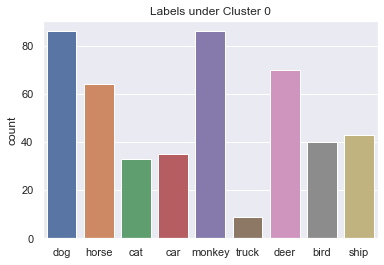

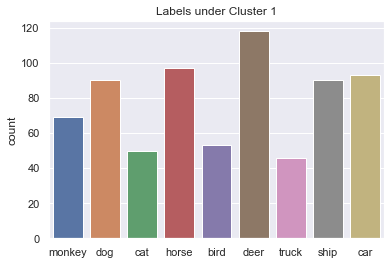

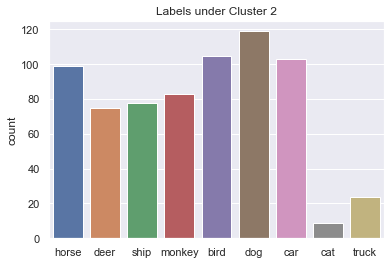

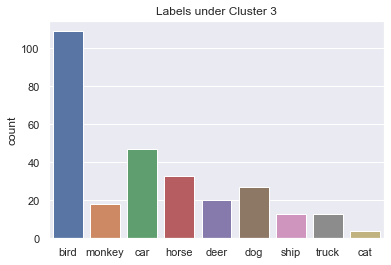

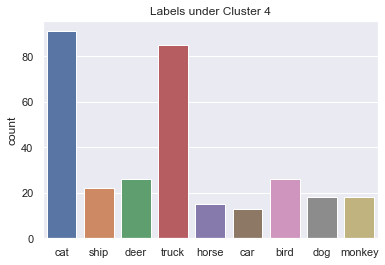

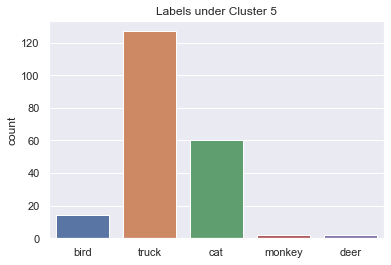

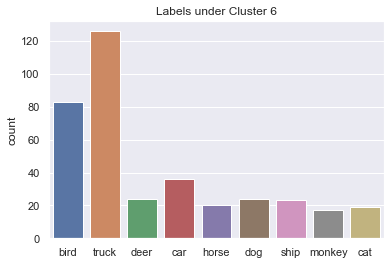

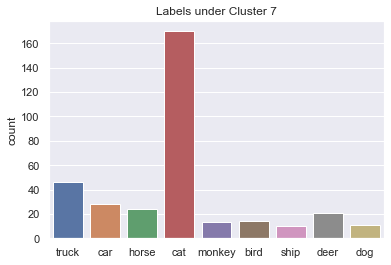

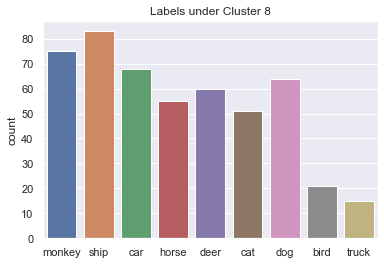

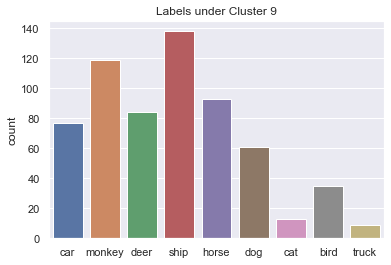

In [123]:
# Check distribution of each formed cluster

import seaborn as sns
sns.set(style="darkgrid")

#ax = sns.countplot(x="class", data=titanic)


clustered_labels = [[gmm_clusters[i],labels_classes[i]] for i in range(len(labels_classes))]
for i in np.unique(gmm_clusters):
    cluster = []
    for item in clustered_labels:
        if item[0] == i: cluster.append(item[1])
    sns.countplot(cluster)
    plt.title("Labels under Cluster " + str(i))
    plt.show()
    plt.close('all') 
    

### Several clusters already show low accuracy on grouping the same images on the train dataset

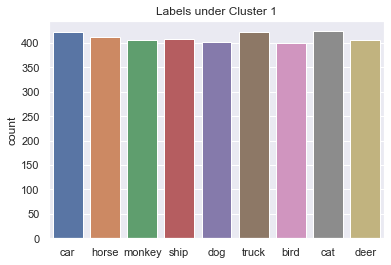

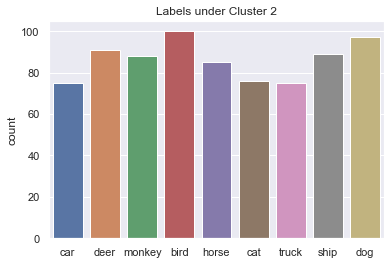

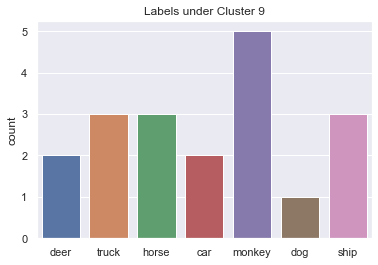

In [124]:
# Try the model in the test dataset
test_images = read_all_images(DATA_PATH_TEST_X)
test_images = np.array([color2gray(i) for i in test_images])
orig_images = test_images
flat_images = flatten_all(orig_images)
                          
PCA_reduced,eigenvecs =  compute_PCA(flat_images,1024)

gmm_clusters = gmm_model.predict(PCA_reduced)

labels_y = read_labels(DATA_PATH_TRAIN_Y)
labels_classes = (pd.Series(labels_y)).map(classes) 
labels_classes = list(labels_classes)

clustered_labels = [[gmm_clusters[i],labels_classes[i]] for i in range(len(labels_classes))]
for i in np.unique(gmm_clusters):
    cluster = []
    for item in clustered_labels:
        if item[0] == i: cluster.append(item[1])
    sns.countplot(cluster)
    plt.title("Labels under Cluster " + str(i))
    plt.show()
    plt.close('all') 

#### High error on test dataset, resulting to identifying three clusters only.
We get a low classification on the test data (relatively low accuracy)